In [3]:
import time
import numpy as np
import gym
from gym import spaces
from collections import defaultdict
import math
import itertools
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Environment

In [4]:
class SmartCharging(gym.Env):
    def __init__(self, actions, cap, stuck_penalty):
        super(SmartCharging, self).__init__()
        
        self.actions = actions  
        self.cap = cap
        self.stuck_penalty = stuck_penalty
        
        self.action_space = spaces.Discrete(len(self.actions))
        self.observation_space = spaces.Dict({
            'level': spaces.Discrete(self.cap+1),
            'time': spaces.Discrete(8)
        })
        
        self.state = {
            'level': 0,
            'time': 0
        }      
        
        self.done = False
        
    def reset(self):
        self.state = {
            'level': 0,
            'time': 0
        }
        self.done = False
        return self.state
        
    def step(self, action):
        loaded = self.actions.get(action)
        reward = 0
        if loaded + self.state['level'] > self.cap: #Charging would exceed the total capacity of the battery
            reward -= cost_func(self.state['time'], self.cap - self.state['level'])
            self.state['level'] = self.cap
        else:
            reward -= cost_func(self.state['time'], loaded)
            self.state['level'] += loaded
        
        self.state['time'] += 1
        
        if self.state['time'] == 8:
            if self.state['level'] - power_consumed() >= 0:
                self.reset()
            else:
                self.reset()
                reward += self.stuck_penalty  # Add the stuck penalty directly to the reward
            self.done = True
                
        return self.state, reward, self.done, {}  # Updated the return statement with four values as expected by the Gym environment
    
def cost_func(t, p):
    '''
    This method returns the costs for charging
    @param t:  time
    @param p:  charging rate
    '''
    # alpha_time is the coefficient for time
    alpha_time = [1, 1, 1, 1, 1, 1, 1, 1]
    return alpha_time[t] * p**2

def power_consumed(mu=30, sigma=5):
    '''
    This method returns power consumed by the taxi driver
    @param mu: mean
    @param sigma: standard deviation
    '''
    return int(np.random.normal(mu, sigma, 1)[0])

def plot_q_values(q_table,cap):
    
    def get_Z(key):
        #return max(q_table[key])
        return np.average(q_table[key])
        
    # battery level
    X = np.arange(cap +1)
    # time
    Y = np.arange(8)
    X_grid, Y_grid = np.meshgrid(X, Y)
    # max q-values (policy)
    Z = np.array([get_Z(key) for key in itertools.product(Y,X)]).reshape((8,cap+1))

    fig = plt.figure(figsize=(10, 10))

    # Add a 3D subplot
    #ax = [fig.add_subplot(1, 3, i, projection='3d') for i in range(1, 4)]
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot_surface(X_grid, Y_grid, -Z, cmap='viridis')

    ax.view_init(elev=30, azim=45)

    ax.set_zlabel('max Q-value')
    ax.set_ylabel('Time')
    ax.set_xlabel('Batterie level')
    plt.tight_layout()
    plt.show()
    
def evaluate_q_table(q_table, env, num_episodes=100):
    total_reward = 0

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            # Convert the current state to a tuple used as the key for Q-table lookup
            state_key = (state['time'], state['level'])
            
            # Choose the action with the highest Q-value for the current state
            if state_key in q_table:
                action = np.argmax(q_table[state_key])
            else:
                action = env.action_space.sample()  # Handle unseen states by random action

            # Execute the action and observe the result
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            state = next_state

        total_reward += episode_reward

    average_reward = total_reward / num_episodes
    return average_reward

# Agents

## Monte Carlo 

In [5]:
class MC_Agent():
    def __init__(self, alpha, env, epsilon, epsilon_decay, epsilon_min): 
        self.env = env
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.action_space_size = env.action_space.n 
        self.q_table = defaultdict(lambda: np.zeros(self.action_space_size))
        self.q_table_count = defaultdict(lambda: np.zeros(self.action_space_size))

    def pick_action(self, state):
        state_key = (state['time'], state['level'])  # Store state as a tuple
        if state_key in self.q_table:
            action_q_values = self.q_table[state_key] 
            return self.epsilon_greedy(action_q_values)
        else:
            return self.env.action_space.sample()
            
    def epsilon_greedy(self, action_q_values):
        policy = np.ones(self.action_space_size) * self.epsilon / self.action_space_size
        best_action = np.argmax(action_q_values)
        policy[best_action] = 1 - self.epsilon + (self.epsilon / self.action_space_size) 

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return np.random.choice(self.action_space_size, p=policy)

    def update_q_values(self, state, action, goal):
        state_key = (state['time'], state['level'])  # Store state as a tuple
        
        self.q_table_count[state_key][action] += 1
        learning_rate = self.alpha / self.q_table_count[state_key][action]
        self.q_table[state_key][action] += learning_rate * (goal - self.q_table[state_key][action])
        
    def train(self,iterations):
        for i in range(iterations):
            state = self.env.reset()
            episode = []
            done = False

            while not done:
                action = self.pick_action(state)
                old_state = state.copy()
                state, reward, done, _= self.env.step(action)
                episode.append((old_state, action, reward))

            goal = 0
            for state, action, reward in reversed(episode):
                goal += reward
                self.update_q_values(state, action, goal)
        return self.q_table

## SARSA

In [13]:
class SARSA_Agent():
    def __init__(self, alpha, gamma, env, epsilon, epsilon_decay, epsilon_min):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.action_space_size = env.action_space.n
        self.q_table = defaultdict(lambda: np.zeros(self.action_space_size))

    def pick_action(self, state):
        state_key = (state['time'], state['level'])  # Store state as a tuple
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state_key])
            
    def epsilon_greedy(self, action_q_values):
        policy = np.ones(self.action_space_size) * self.epsilon / self.action_space_size
        best_action = np.argmax(action_q_values)
        policy[best_action] = 1 - self.epsilon + (self.epsilon / self.action_space_size)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return np.random.choice(self.action_space_size, p=policy)

    def update_q_values(self, state, action, reward, next_state, next_action, done):
        state_key = (state['time'], state['level'])
        next_state_key = (next_state['time'], next_state['level'])

        td_target = reward + self.gamma * self.q_table[next_state_key][next_action] * (1 - done)
        td_error = td_target - self.q_table[state_key][action]
        
        self.q_table[state_key][action] += self.alpha * td_error

    def train(self, iterations):
        for i in range(iterations):
            state = self.env.reset()
            action = self.pick_action(state)
            done = False

            while not done:
                next_state, reward, done, _ = self.env.step(action)
                next_action = self.pick_action(next_state)
                self.update_q_values(state, action, reward, next_state, next_action, done)
                
                state = next_state
                action = next_action
                
            # Decay epsilon after each episode
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
        
        return self.q_table

## Q Learning

In [11]:
class QLearning_Agent():
    def __init__(self, alpha, gamma, env, epsilon, epsilon_decay, epsilon_min):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.action_space_size = env.action_space.n 
        self.q_table = defaultdict(lambda: np.zeros(self.action_space_size))

    def pick_action(self, state):
        state_key = (state['time'], state['level'])  # Store state as a tuple
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state_key])
            
    def epsilon_greedy(self, action_q_values):
        policy = np.ones(self.action_space_size) * self.epsilon / self.action_space_size
        best_action = np.argmax(action_q_values)
        policy[best_action] = 1 - self.epsilon + (self.epsilon / self.action_space_size) 

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return np.random.choice(self.action_space_size, p=policy)

    def update_q_values(self, state, action, reward, next_state, done):
        state_key = (state['time'], state['level'])
        next_state_key = (next_state['time'], next_state['level'])
        
        best_next_action = np.argmax(self.q_table[next_state_key])
        td_target = reward + self.gamma * self.q_table[next_state_key][best_next_action] * (1 - done)
        td_error = td_target - self.q_table[state_key][action]
        
        self.q_table[state_key][action] += self.alpha * td_error
        
    def train(self, iterations):
        for i in range(iterations):
            state = self.env.reset()
            done = False

            while not done:
                action = self.pick_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.update_q_values(state, action, reward, next_state, done)
                state = next_state
                
            # Decay epsilon after each episode
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
        
        return self.q_table


## Deep Q-Network

In [7]:
class DQN_Agent():
    def __init__(self, env, alpha, gamma, epsilon, epsilon_decay, epsilon_min, memory_size, batch_size, target_update=10):
        self.env = env
        self.state_size = 2
        self.action_size = env.action_space.n
        self.alpha = alpha
        self.gamma = gamma 
        self.epsilon = epsilon  
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update = target_update
        
        # Experience replay memory
        self.memory = deque(maxlen=memory_size)

        # Q-network
        self.model = self.build_model()

        # Target Q-network
        self.target_model = self.build_model()
        self.update_target_model()

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.alpha)

    def build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)
        )
        return model

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def pick_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Exploration
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()  # Exploitation

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return 

        minibatch = random.sample(self.memory, self.batch_size)

        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = reward
            if not done:
                target += self.gamma * torch.max(self.target_model(next_state)).item()
            
            target_f = self.model(state)
            target_f[action] = target

            loss = nn.MSELoss()(self.model(state), target_f)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def generate_state_space_keys(self):
        state_space_keys = []
        for time in range(self.env.observation_space['time'].n):
            for level in range(self.env.observation_space['level'].n):
                state_space_keys.append((time, level))
        return state_space_keys

    def extract_q_table(self):
        q_table = {}
        state_space_keys = self.generate_state_space_keys()

        for state_key in state_space_keys:
            state = torch.FloatTensor(state_key).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state).numpy().flatten()
            q_table[state_key] = q_values

        return q_table

    def train(self, episodes):
        for e in range(episodes):
            state = self.env.reset()
            state = np.array([state['time'], state['level']])
            done = False
            total_reward = 0

            while not done:
                action = self.pick_action(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.array([next_state['time'], next_state['level']])
                total_reward += reward
                self.store_experience(state, action, reward, next_state, done)
                state = next_state
                self.replay()

            if e % self.target_update == 0:
                self.update_target_model()

            print(f"Episode {e+1}/{episodes} - Reward: {total_reward}, Epsilon: {self.epsilon:.2f}")

        return self.extract_q_table()


# Execution

In [8]:
actions = {i: i for i in range(23)}
env = SmartCharging(actions=actions, cap=80, stuck_penalty=-2000)

In [27]:
MC_q_table = MC_Agent(alpha=0.01, env=env, epsilon=0.1, epsilon_decay=0.9, epsilon_min=0.01).train(1000)
SARSA_q_table = SARSA_Agent(alpha=0.01, gamma=1, env=env, epsilon=0.1, epsilon_decay=0.99, epsilon_min=0.01).train(1000)
DQN_q_table = DQN_Agent(env=env, alpha=0.01, gamma=1, epsilon=0.2, epsilon_decay=0.99, epsilon_min=0.01, memory_size=10000, batch_size=32, target_update=10).train(10)

Episode 1/10 - Reward: -664, Epsilon: 0.20
Episode 2/10 - Reward: -850, Epsilon: 0.20
Episode 3/10 - Reward: -719, Epsilon: 0.20
Episode 4/10 - Reward: -536, Epsilon: 0.20
Episode 5/10 - Reward: -2621, Epsilon: 0.18
Episode 6/10 - Reward: -1122, Epsilon: 0.17
Episode 7/10 - Reward: -1016, Epsilon: 0.16
Episode 8/10 - Reward: -568, Epsilon: 0.14
Episode 9/10 - Reward: -2425, Epsilon: 0.13
Episode 10/10 - Reward: -246, Epsilon: 0.12


In [28]:
MC_avg = evaluate_q_table(MC_q_table, env, num_episodes=100)
print("MC_avg: ", MC_avg)
SARSA_avg = evaluate_q_table(SARSA_q_table, env, num_episodes=100)
print("SARSA_avg: ", SARSA_avg)
DQN_avg = evaluate_q_table(DQN_q_table, env, num_episodes=100)
print("DQN_avg: ", DQN_avg)

MC_avg:  -1034.0
SARSA_avg:  -2000.0
DQN_avg:  -296.0


Episode 1/1000 - Reward: -1018, Epsilon: 0.20
Episode 2/1000 - Reward: -709, Epsilon: 0.20
Episode 3/1000 - Reward: -954, Epsilon: 0.20
Episode 4/1000 - Reward: -634, Epsilon: 0.20
Episode 5/1000 - Reward: -873, Epsilon: 0.18
Episode 6/1000 - Reward: -1296, Epsilon: 0.17
Episode 7/1000 - Reward: -951, Epsilon: 0.16
Episode 8/1000 - Reward: -299, Epsilon: 0.14
Episode 9/1000 - Reward: -324, Epsilon: 0.13
Episode 10/1000 - Reward: -2328, Epsilon: 0.12
Episode 11/1000 - Reward: -414, Epsilon: 0.11
Episode 12/1000 - Reward: -355, Epsilon: 0.10
Episode 13/1000 - Reward: -2466, Epsilon: 0.10
Episode 14/1000 - Reward: -426, Epsilon: 0.09
Episode 15/1000 - Reward: -122, Epsilon: 0.08
Episode 16/1000 - Reward: -410, Epsilon: 0.08
Episode 17/1000 - Reward: -2013, Epsilon: 0.07
Episode 18/1000 - Reward: -2052, Epsilon: 0.06
Episode 19/1000 - Reward: -2085, Epsilon: 0.06
Episode 20/1000 - Reward: -2036, Epsilon: 0.05
Episode 21/1000 - Reward: -2109, Epsilon: 0.05
Episode 22/1000 - Reward: -2091, E

Episode 177/1000 - Reward: -589, Epsilon: 0.01
Episode 178/1000 - Reward: -614, Epsilon: 0.01
Episode 179/1000 - Reward: -689, Epsilon: 0.01
Episode 180/1000 - Reward: -449, Epsilon: 0.01
Episode 181/1000 - Reward: -534, Epsilon: 0.01
Episode 182/1000 - Reward: -248, Epsilon: 0.01
Episode 183/1000 - Reward: -284, Epsilon: 0.01
Episode 184/1000 - Reward: -559, Epsilon: 0.01
Episode 185/1000 - Reward: -445, Epsilon: 0.01
Episode 186/1000 - Reward: -461, Epsilon: 0.01
Episode 187/1000 - Reward: -278, Epsilon: 0.01
Episode 188/1000 - Reward: -309, Epsilon: 0.01
Episode 189/1000 - Reward: -407, Epsilon: 0.01
Episode 190/1000 - Reward: -333, Epsilon: 0.01
Episode 191/1000 - Reward: -274, Epsilon: 0.01
Episode 192/1000 - Reward: -225, Epsilon: 0.01
Episode 193/1000 - Reward: -293, Epsilon: 0.01
Episode 194/1000 - Reward: -243, Epsilon: 0.01
Episode 195/1000 - Reward: -414, Epsilon: 0.01
Episode 196/1000 - Reward: -200, Epsilon: 0.01
Episode 197/1000 - Reward: -325, Epsilon: 0.01
Episode 198/1

Episode 351/1000 - Reward: -272, Epsilon: 0.01
Episode 352/1000 - Reward: -200, Epsilon: 0.01
Episode 353/1000 - Reward: -319, Epsilon: 0.01
Episode 354/1000 - Reward: -200, Epsilon: 0.01
Episode 355/1000 - Reward: -239, Epsilon: 0.01
Episode 356/1000 - Reward: -176, Epsilon: 0.01
Episode 357/1000 - Reward: -200, Epsilon: 0.01
Episode 358/1000 - Reward: -200, Epsilon: 0.01
Episode 359/1000 - Reward: -2096, Epsilon: 0.01
Episode 360/1000 - Reward: -376, Epsilon: 0.01
Episode 361/1000 - Reward: -451, Epsilon: 0.01
Episode 362/1000 - Reward: -257, Epsilon: 0.01
Episode 363/1000 - Reward: -305, Epsilon: 0.01
Episode 364/1000 - Reward: -242, Epsilon: 0.01
Episode 365/1000 - Reward: -515, Epsilon: 0.01
Episode 366/1000 - Reward: -201, Epsilon: 0.01
Episode 367/1000 - Reward: -288, Epsilon: 0.01
Episode 368/1000 - Reward: -279, Epsilon: 0.01
Episode 369/1000 - Reward: -343, Epsilon: 0.01
Episode 370/1000 - Reward: -288, Epsilon: 0.01
Episode 371/1000 - Reward: -320, Epsilon: 0.01
Episode 372/

Episode 525/1000 - Reward: -500, Epsilon: 0.01
Episode 526/1000 - Reward: -593, Epsilon: 0.01
Episode 527/1000 - Reward: -190, Epsilon: 0.01
Episode 528/1000 - Reward: -434, Epsilon: 0.01
Episode 529/1000 - Reward: -425, Epsilon: 0.01
Episode 530/1000 - Reward: -380, Epsilon: 0.01
Episode 531/1000 - Reward: -335, Epsilon: 0.01
Episode 532/1000 - Reward: -309, Epsilon: 0.01
Episode 533/1000 - Reward: -486, Epsilon: 0.01
Episode 534/1000 - Reward: -344, Epsilon: 0.01
Episode 535/1000 - Reward: -265, Epsilon: 0.01
Episode 536/1000 - Reward: -200, Epsilon: 0.01
Episode 537/1000 - Reward: -200, Epsilon: 0.01
Episode 538/1000 - Reward: -200, Epsilon: 0.01
Episode 539/1000 - Reward: -200, Epsilon: 0.01
Episode 540/1000 - Reward: -269, Epsilon: 0.01
Episode 541/1000 - Reward: -413, Epsilon: 0.01
Episode 542/1000 - Reward: -425, Epsilon: 0.01
Episode 543/1000 - Reward: -145, Epsilon: 0.01
Episode 544/1000 - Reward: -299, Epsilon: 0.01
Episode 545/1000 - Reward: -248, Epsilon: 0.01
Episode 546/1

Episode 700/1000 - Reward: -392, Epsilon: 0.01
Episode 701/1000 - Reward: -606, Epsilon: 0.01
Episode 702/1000 - Reward: -254, Epsilon: 0.01
Episode 703/1000 - Reward: -575, Epsilon: 0.01
Episode 704/1000 - Reward: -367, Epsilon: 0.01
Episode 705/1000 - Reward: -237, Epsilon: 0.01
Episode 706/1000 - Reward: -144, Epsilon: 0.01
Episode 707/1000 - Reward: -455, Epsilon: 0.01
Episode 708/1000 - Reward: -88, Epsilon: 0.01
Episode 709/1000 - Reward: -2036, Epsilon: 0.01
Episode 710/1000 - Reward: -2401, Epsilon: 0.01
Episode 711/1000 - Reward: -2401, Epsilon: 0.01
Episode 712/1000 - Reward: -437, Epsilon: 0.01
Episode 713/1000 - Reward: -184, Epsilon: 0.01
Episode 714/1000 - Reward: -207, Epsilon: 0.01
Episode 715/1000 - Reward: -324, Epsilon: 0.01
Episode 716/1000 - Reward: -207, Epsilon: 0.01
Episode 717/1000 - Reward: -2207, Epsilon: 0.01
Episode 718/1000 - Reward: -264, Epsilon: 0.01
Episode 719/1000 - Reward: -320, Epsilon: 0.01
Episode 720/1000 - Reward: -512, Epsilon: 0.01
Episode 72

Episode 874/1000 - Reward: -2072, Epsilon: 0.01
Episode 875/1000 - Reward: -152, Epsilon: 0.01
Episode 876/1000 - Reward: -193, Epsilon: 0.01
Episode 877/1000 - Reward: -194, Epsilon: 0.01
Episode 878/1000 - Reward: -128, Epsilon: 0.01
Episode 879/1000 - Reward: -195, Epsilon: 0.01
Episode 880/1000 - Reward: -363, Epsilon: 0.01
Episode 881/1000 - Reward: -202, Epsilon: 0.01
Episode 882/1000 - Reward: -239, Epsilon: 0.01
Episode 883/1000 - Reward: -341, Epsilon: 0.01
Episode 884/1000 - Reward: -329, Epsilon: 0.01
Episode 885/1000 - Reward: -152, Epsilon: 0.01
Episode 886/1000 - Reward: -200, Epsilon: 0.01
Episode 887/1000 - Reward: -200, Epsilon: 0.01
Episode 888/1000 - Reward: -1080, Epsilon: 0.01
Episode 889/1000 - Reward: -1080, Epsilon: 0.01
Episode 890/1000 - Reward: -1080, Epsilon: 0.01
Episode 891/1000 - Reward: -1080, Epsilon: 0.01
Episode 892/1000 - Reward: -1080, Epsilon: 0.01
Episode 893/1000 - Reward: -1080, Epsilon: 0.01
Episode 894/1000 - Reward: -1080, Epsilon: 0.01
Episo

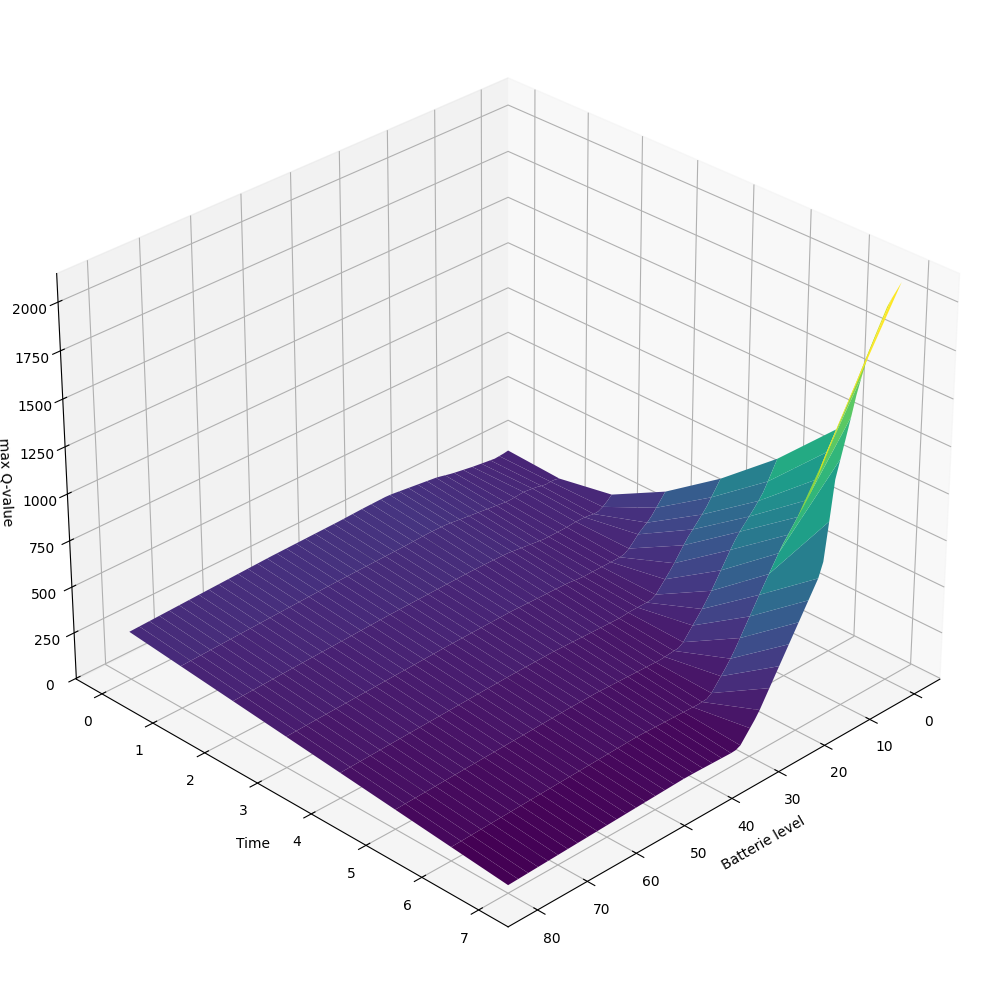

In [42]:
q_table = agent.train(episodes=100)
plot_q_values(q_table, env.cap)

Monte Carlo, Q-learning (double) , Deep Q-Network, SARSA